C:\Users\Kerry\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


(324, 272, 1)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 117, 8)            200       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 117, 8)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 117, 8)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 49, 8)             1288      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 49, 8)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 49, 8)             0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16, 

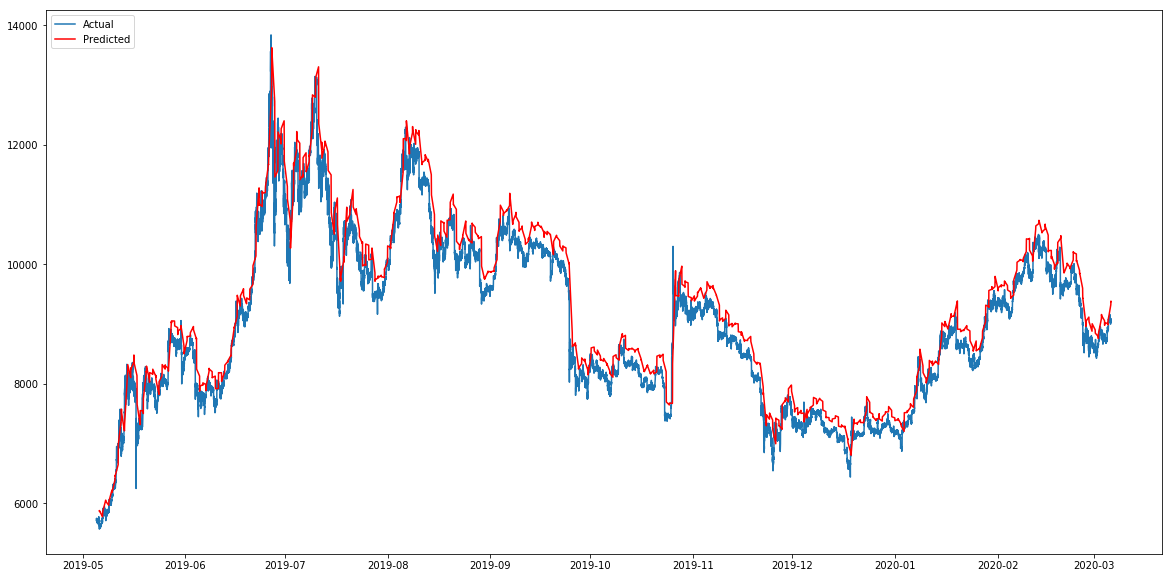

In [6]:
from keras import applications
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.callbacks import CSVLogger
import tensorflow as tf
from imageio import imread
import numpy as np
import random
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras import optimizers
import h5py
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
import matplotlib.pyplot as plt


# Options
Price_Source = 'close' # close or ohlc
Layer_Number = 3 # 2,3 or 4
Activation_Func = 'leaky_relu' # relu or leaky_relu
Model_Code = '100' # number of training epochs


if Price_Source == 'close':
    input_file_name = 'bitcoin2016-2020_close.h5'
    
with h5py.File(''.join([input_file_name]), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value
    input_times = hf['input_times'].value
    output_times = hf['output_times'].value
    original_inputs = hf['original_inputs'].value
    original_outputs = hf['original_outputs'].value
    original_datas = hf['original_datas'].value
    

file_path = Price_Source + '_CNN_' + str(Layer_Number) + '_' + Activation_Func

    
scaler=MinMaxScaler()
#split training validation
training_size = int(0.8* datas.shape[0])
training_datas = datas[:training_size,:,:] #训练集样本价格
training_labels = labels[:training_size,:,:] #训练集标签价格
validation_datas = datas[training_size:,:,:] #测试集样本价格
validation_labels = labels[training_size:,:,:] #测试集标签价格
validation_original_inputs = original_inputs[training_size:,:,:] #标准化之前测试集样本价格
validation_original_outputs = original_outputs[training_size:,:,:] #标准化化之前测试集标签价格
validation_input_times = input_times[training_size:,:,:] #测试集的输入样本的日期
validation_output_times = output_times[training_size:,:,:] #测试集的输出结果的日期


ground_true = np.append(validation_original_inputs,validation_original_outputs, axis=1)
ground_true_times = np.append(validation_input_times,validation_output_times, axis=1)
ground_true = ground_true[:,:,0].reshape(-1)
print(ground_true_times.shape)
ground_true_times = pd.to_datetime(ground_true_times.reshape(-1), unit = 's')
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true
                                   
                                   
# build model
step_size = datas.shape[1]
batch_size= 8
nb_features = datas.shape[2]
epochs = 1
model = Sequential()

if Activation_Func == 'relu':
    
    if Layer_Number == 2:
        # 2 layers
        model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=20))
        # model.add(LeakyReLU())
        model.add(Dropout(0.25))
        model.add(Conv1D( strides=4, filters=nb_features, kernel_size=16))

    elif Layer_Number == 3:
        # 3 layers
        model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=2, filters=8, kernel_size=24))
        # model.add(LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=20))
        # model.add(LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Conv1D( strides=2, filters=nb_features, kernel_size=18))
        model.summary()
        
    elif Layer_Number == 4:
        # 4 layers
        model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=2, filters=8, kernel_size=26))
        # model.add(LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=22))
        # model.add(LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Conv1D(activation='relu', strides=1, filters=8, kernel_size=18))
        # model.add(LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Conv1D( strides=1, filters=nb_features, kernel_size=16))
        
elif Activation_Func == 'leaky_relu':
    
    if Layer_Number == 2:
        # 2 layers
        model.add(Conv1D(input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=20))
        model.add(LeakyReLU())
        model.add(Dropout(0.25))
        model.add(Conv1D( strides=4, filters=nb_features, kernel_size=16))

    elif Layer_Number == 3:
        # 3 layers
        model.add(Conv1D(input_shape=(step_size, nb_features), strides=2, filters=8, kernel_size=24))
        model.add(LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Conv1D(strides=2, filters=8, kernel_size=20))
        model.add(LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Conv1D( strides=2, filters=nb_features, kernel_size=18))
        model.summary()
        
    elif Layer_Number == 4:
        # 4 layers
        model.add(Conv1D(input_shape=(step_size, nb_features), strides=2, filters=8, kernel_size=26))
        model.add(LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Conv1D(strides=2, filters=8, kernel_size=22))
        model.add(LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Conv1D(strides=1, filters=8, kernel_size=18))
        model.add(LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Conv1D(strides=1, filters=nb_features, kernel_size=16))

        
model.load_weights('weights/'+file_path+'/'+'bitcoin2016-2020_' + Price_Source + '_CNN_' + str(Layer_Number) + '_' + Activation_Func + '-' + Model_Code + '.hdf5')
model.compile(loss='mse', optimizer='adam')
                                   
                        
predicted = model.predict(validation_datas)
predicted_inverted = []
for i in range(original_datas.shape[1]):
    scaler.fit(original_datas[:,i].reshape(-1,1))
    predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))
# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print(validation_output_times.shape)
validation_output_times = pd.to_datetime(validation_output_times.reshape(-1), unit = 's')
prediction_df = pd.DataFrame()
prediction_df['times'] = validation_output_times
prediction_df['value'] = predicted_inverted
     
    
# timestamp1 = '2019-05-06 01:20:00'
# timestamp2 = '2019-05-10 0:00:00'
# ground_true_df_plot = ground_true_df.loc[(ground_true_df["times"] >= timestamp1)&(ground_true_df["times"] <= timestamp2),:]
# prediction_df_plot = prediction_df.loc[(prediction_df["times"] >= timestamp1)&(prediction_df["times"] <= timestamp2),:]
# plt.figure(figsize=(20,10))
# plt.plot(ground_true_df_plot.times,ground_true_df_plot.value, label = 'Actual')
# plt.plot(prediction_df_plot.times,prediction_df_plot.value, 'r.', label='Predicted')
# plt.legend(loc='upper left')
                                   
                                   
plt.figure(figsize=(20,10))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.times,prediction_df.value, 'r', label='Predicted')
plt.legend(loc='upper left')


plt.savefig('result/bitcoin2016-2020_'+Price_Source+'_CNN_'+str(Layer_Number)+'_'+Activation_Func+'_result.png')
plt.show()